In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colormaps
import ipywidgets as ipw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [2]:
ABX_NB_SAMPLES = 50
QUANTIZER_ABX_DISTANCE = {
    "quantized_latent": {
        "metric": "cosine",
        "weight": 1,
    }
}
NB_TRAINING = 5

DATASET_NAME = "pb2007"
MODALITIES = ["cepstrum", "art_params"]
NB_TRAINING = 5
VARIATIONS = {
    "frame_padding": [0, 1, 2, 3, 5],
    "num_embeddings": [32, 64, 128, 256, 512, 1024, 2048],
}

In [3]:
quantizers_path = glob("../out/quantizer/*/")
quantizers_path.sort()

In [4]:
quantizers_abx_matrices = utils.pickle_load("../out/quantizer/abx_cache.pickle", {})

In [5]:
for quantizer_path in tqdm(quantizers_path):    
    if quantizer_path not in quantizers_abx_matrices:
        quantizers_abx_matrices[quantizer_path] = {}
    quantizer_abx_matrices = quantizers_abx_matrices[quantizer_path]
    
    distance = QUANTIZER_ABX_DISTANCE
    distance_signature = abx_utils.get_distance_signature(distance)
    if distance_signature in quantizer_abx_matrices: continue
    
    quantizer = Quantizer.reload(quantizer_path)
    
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)

    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES)
    quantizer_abx_matrices[distance_signature] = abx_matrix
    utils.pickle_dump("../out/quantizer/abx_cache.pickle", quantizers_abx_matrices)

  0%|          | 0/1374 [00:00<?, ?it/s]

In [8]:
results = {}

distance = QUANTIZER_ABX_DISTANCE
distance_signature = abx_utils.get_distance_signature(distance)
    
for modality in MODALITIES:
    modality_results = results[modality] = {}

    for variation_parameter, variation_values in VARIATIONS.items():
        variation_results = modality_results[variation_parameter] = {}

        final_configs = utils.read_yaml_file(
            "quantizer_final_configs.yaml"
        )
        config_name = "%s-%s" % (DATASET_NAME, modality)
        config = final_configs[config_name]

        for variation_value in variation_values:
            value_results = variation_results[variation_value] = []
            config["model"][variation_parameter] = variation_value

            for i_training in range(NB_TRAINING):
                config["dataset"]["datasplit_seed"] = i_training
                signature = utils.get_variable_signature(config)
                save_path = "../out/quantizer/%s-%s/" % (signature, i_training)
                quantizer_matrix = quantizers_abx_matrices[save_path][distance_signature]

                value_results.append(quantizer_matrix)

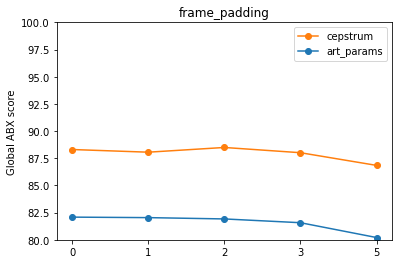

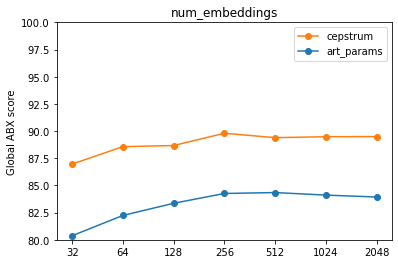

In [9]:
dataset = Dataset(DATASET_NAME)
consonants = dataset.phones_infos["consonants"]
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
    "agent_art": "tab:pink",
}
    

for variation_parameter, variation_values in VARIATIONS.items():
    plt.figure()
    ax = plt.subplot()
    ax.set_title(variation_parameter)
    ax.set_ylim(80, 100)
    ax.set_ylabel("Global ABX score")
    
    for modality in MODALITIES:
        modality_abx_scores = []
        
        xlabels = []
        for value_i, variation_value in enumerate(variation_values):
            xlabels.append(variation_value)
            
            global_abx_scores = []
            
            for i_training in range(NB_TRAINING):
                quantizer_matrix = results[modality][variation_parameter][variation_value][i_training]
                quantizer_global_abx_score = abx_utils.get_global_score(quantizer_matrix)
                global_abx_scores.append(quantizer_global_abx_score)
                
            global_abx_score = np.mean(global_abx_scores)
            modality_abx_scores.append(global_abx_score)
        ax.plot(modality_abx_scores, marker="o", label=modality, color=colors[modality])
    
    ax.set_xticks(np.arange(len(xlabels)), xlabels)
    ax.legend()

    plt.show()